# ResNet50  pretrained model on Synthetic Microscopy Images

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
from seaborn import heatmap
from sklearn.metrics import confusion_matrix
import time 

import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# Preprocessing and Make datasets

### Defining Folders and check some images

Total number of classes is 13 and total number of images is  3064
the size of the image is  (600, 600)
the maximum value in image is  255


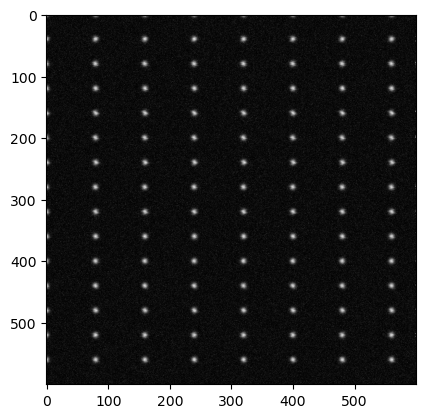

In [3]:
# The original images were classified in the folder: random-lattices
folder_path = os.path.join(os.getcwd(), "random-lattices")

# Calculate the total number of classes and images
classes = os.listdir(folder_path)

tot_number_images = 0

for each_class in classes:    
    tot_number_images += len(list(filter(lambda x: x.endswith(".png"), os.listdir(os.path.join(folder_path, each_class)))))
    
print(f"Total number of classes is {len(classes)} and total number of images is  {tot_number_images}")

# look at a random image to check
def random_image(path):
    #path=glob(train_folder+"/*/*.png")
    a=image.load_img(np.random.choice(path))
    plt.imshow(a)
    print("the size of the image is ",a.size)
    print("the maximum value in image is ",np.max(a))
    plt.show()

random_image(glob(folder_path+"/*/*.png"))

In [4]:
dim1=[]
dim2=[]

for cs in os.listdir(folder_path):
    cs_path = os.path.join(folder_path, cs)
    for image_filename in os.listdir(cs_path):
        image_path = os.path.join(cs_path, image_filename)
        with Image.open(image_path) as img:    # Image.open from PIL library
            width, height = img.size
            dim1.append(width)
            dim2.append(height)
            
# We can choose the minimum image size or the average image size depends on available resources for computation
image_shape=(int(np.min(dim1)), int(np.min(dim2)))
#image_shape=(int(np.average(dim1)), int(np.average(dim2)))

image_shape

(600, 600)

## Image Augmentation and Dataset Splitting

In [6]:
image_size=[image_shape[0], image_shape[1]]

batch_size = 16
epochs = 15

Found 3064 files belonging to 13 classes.
Using 2145 files for training.
Found 3064 files belonging to 13 classes.
Using 919 files for validation.


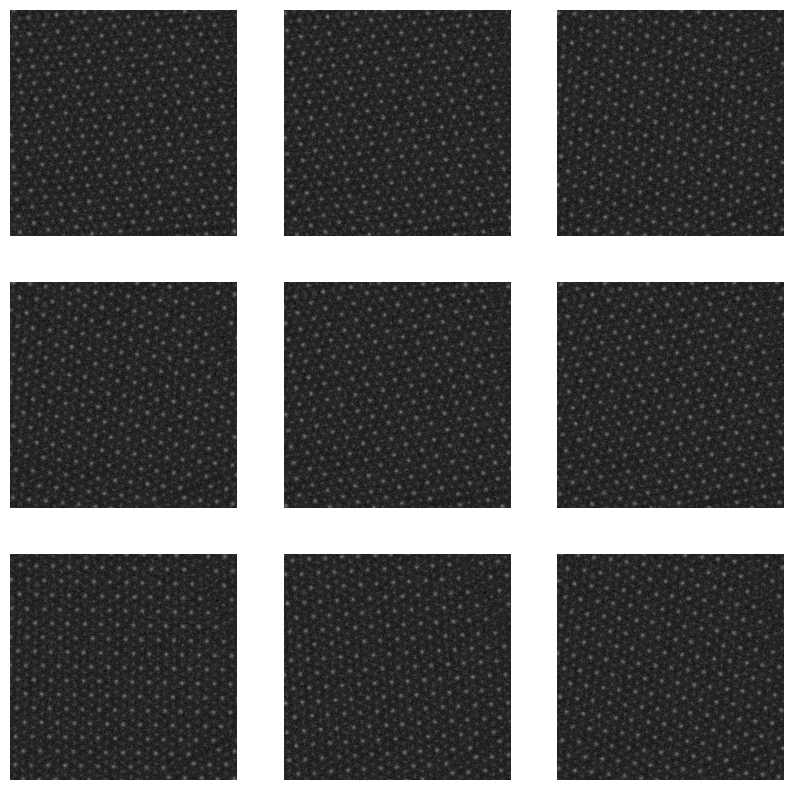

In [7]:
#For data augmentation, we can add few layers. I just used some rotation. 
data_augmentation = Sequential([
                            layers.experimental.preprocessing.RandomRotation(factor = (0, 0.1)),
                                ])

from tensorflow.keras.preprocessing.image import load_img, img_to_array

#Plotting a random image and apply data augmentation

#Load an image using load_image
image1=load_img(np.random.choice(glob(folder_path+"/*/*.png")), target_size = (image_size[0], image_size[1]))

image_array = img_to_array(image1)/255.0  

# Add the image to a batch with TensorShape([1, 600, 600, 3])
random_image = tf.cast(tf.expand_dims(image_array, 0), "float32")

plt.figure(figsize=(10,10))
for i in range(9):
    augmented_image = data_augmentation (random_image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0])
    plt.axis("off")
    
    
# it yields `float32` tensors of shape `(batch_size, image_size[0], image_size[1], num_channels)`
ds_train = image_dataset_from_directory(
    directory = folder_path, 
    validation_split= 0.3, 
    subset = "training", 
    label_mode = "categorical",
    labels = "inferred",
    seed = 123, 
    image_size= (image_size[0], image_size[1]), 
    batch_size = batch_size
    )  

# it yields `float32` tensors of shape `(batch_size, image_size[0], image_size[1], num_channels)`
ds_valid = image_dataset_from_directory(
    directory = folder_path, 
    validation_split= 0.3, 
    subset = "validation", 
    label_mode = "categorical",
    labels = "inferred",
    seed = 123, 
    image_size= (image_size[0], image_size[1]), 
    batch_size = batch_size
    )

In [21]:
#Let's test datasets:
one_image = ds_train.take(1)
for image1, label1 in one_image:
    print(image1.shape)
    print(image1.dtype)
    print(classes[np.argmax(label1)])

(16, 600, 600, 3)
<dtype: 'float32'>
teteragonal_body_center


In [9]:
train_size = len(ds_train.file_paths)
valid_size = len(ds_valid.file_paths)

it = iter(ds_train)
x, y = next(it)
print("The dimension of the data ", x.shape, "and label ", y.shape)

AUTOTUNE = tf.data.AUTOTUNE

def prepare (ds, shuffle=False, augment=False):
    """
    A function to apply image augmentation on dataset if augment is True. It shuffles the dataset if the shuffle is True, 
    The function applies prefetch and on datasets. 
    """
    
    if shuffle:
        ds = ds.shuffle(len(ds))
    if augment:
        ds = ds.map(lambda x,y: (data_augmentation(x, training = True), y), num_parallel_calls = AUTOTUNE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    ds = ds.cache()
    ds = ds.repeat(count = 20)
    
    return ds
train_ds = prepare(ds_train, shuffle= True, augment= True)
print("Train Dataset", train_ds)

#rescaled = layers.experimental.preprocessing.Rescaling(1/255.0)
#ds_valid_rescaled = ds_valid.map (lambda x, y: (rescaled(x), y))
valid_ds = prepare(ds_valid, shuffle= False, augment= False)
print("Valid Dataset", valid_ds)

The dimension of the data  (16, 600, 600, 3) and label  (16, 13)
Train Dataset <RepeatDataset shapes: ((None, 600, 600, 3), (None, 13)), types: (tf.float32, tf.float32)>
Valid Dataset <RepeatDataset shapes: ((None, 600, 600, 3), (None, 13)), types: (tf.float32, tf.float32)>


## Deploying Model and add dense layers

In [10]:
resnet = ResNet50(input_shape=image_size+[3], 
                include_top=False,
                weights="imagenet"
               )

for layer in resnet.layers:
    layer.trainable=False
    
title = input(f"Please choose a title for files to be save later \n")
#layers
x = Flatten()(resnet.output)
x = layers.experimental.preprocessing.Rescaling (1/255.0)(x)
x=Dense(1024, activation="relu")(x)
x=Dropout(0.2)(x)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.2)(x)
prediction = Dense(len(classes), activation = "softmax")(x)    
model = Model(inputs = resnet.input, outputs = prediction)

Please choose a title for files to be save later 
resnet_1024_512


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 606, 606, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 300, 300, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 300, 300, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
#A folder to save the results
folder_dest = os.path.join(os.getcwd(), "random-lattices-split")

# The default learning rate did not work well for me.
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# Compile the Model
model.compile(
              loss = "categorical_crossentropy", 
              optimizer = optimizer,  
              metrics = ["accuracy"]
            )

summary_model_path = os.path.join(folder_dest, f"summary_{title}")

model.save(summary_model_path)

checkpoint_filepath = os.path.join(folder_dest, f"summary_{title}")

checkpoint = ModelCheckpoint(filepath = checkpoint_filepath, 
                             monitor = 'val_accuracy', 
                             verbose = 0, 
                             save_best_only = True, 
                             save_weights_only = True, 
                             mode='max')

early = EarlyStopping(monitor = 'loss', 
                      min_delta = 0, 
                      patience = 3,
                      verbose = 0, 
                      restore_best_weights = True)

In [13]:
# To avoid warnings only for errors
tf.get_logger().setLevel('ERROR')

start=time.time()

random_lattice_resnet = model.fit(
    train_ds,
    validation_data = valid_ds,
    batch_size = batch_size, 
    epochs = epochs,
    validation_steps = valid_size // batch_size,
    steps_per_epoch  = train_size // batch_size,
    callbacks = [checkpoint, early])

end=time.time()
total_time=(end-start)/60
print("total time in min is :", total_time)

Epoch 1/15
134/134 [==============================] - 36s 195ms/step - loss: 1.4074 - accuracy: 0.5481 - val_loss: 0.9324 - val_accuracy: 0.6480
Epoch 2/15
134/134 [==============================] - 26s 191ms/step - loss: 0.6397 - accuracy: 0.7661 - val_loss: 0.6332 - val_accuracy: 0.7434
Epoch 3/15
134/134 [==============================] - 26s 192ms/step - loss: 0.3848 - accuracy: 0.8643 - val_loss: 0.5090 - val_accuracy: 0.7862
Epoch 4/15
134/134 [==============================] - 26s 193ms/step - loss: 0.2773 - accuracy: 0.9023 - val_loss: 0.5406 - val_accuracy: 0.7654
Epoch 5/15
134/134 [==============================] - 25s 188ms/step - loss: 0.2006 - accuracy: 0.9300 - val_loss: 0.5181 - val_accuracy: 0.7818
Epoch 6/15
134/134 [==============================] - 25s 189ms/step - loss: 0.1607 - accuracy: 0.9413 - val_loss: 0.5106 - val_accuracy: 0.7971
Epoch 7/15
134/134 [==============================] - 26s 192ms/step - loss: 0.1317 - accuracy: 0.9544 - val_loss: 0.4447 - val_ac

In [ ]:
model.save(os.path.join(folder_dest, f"entire_model_{title}"))
model.save_weights(os.path.join(folder_dest, f"entire_model_weights_{title}.h5"))

## Plot Metrics and Confusion Matrix

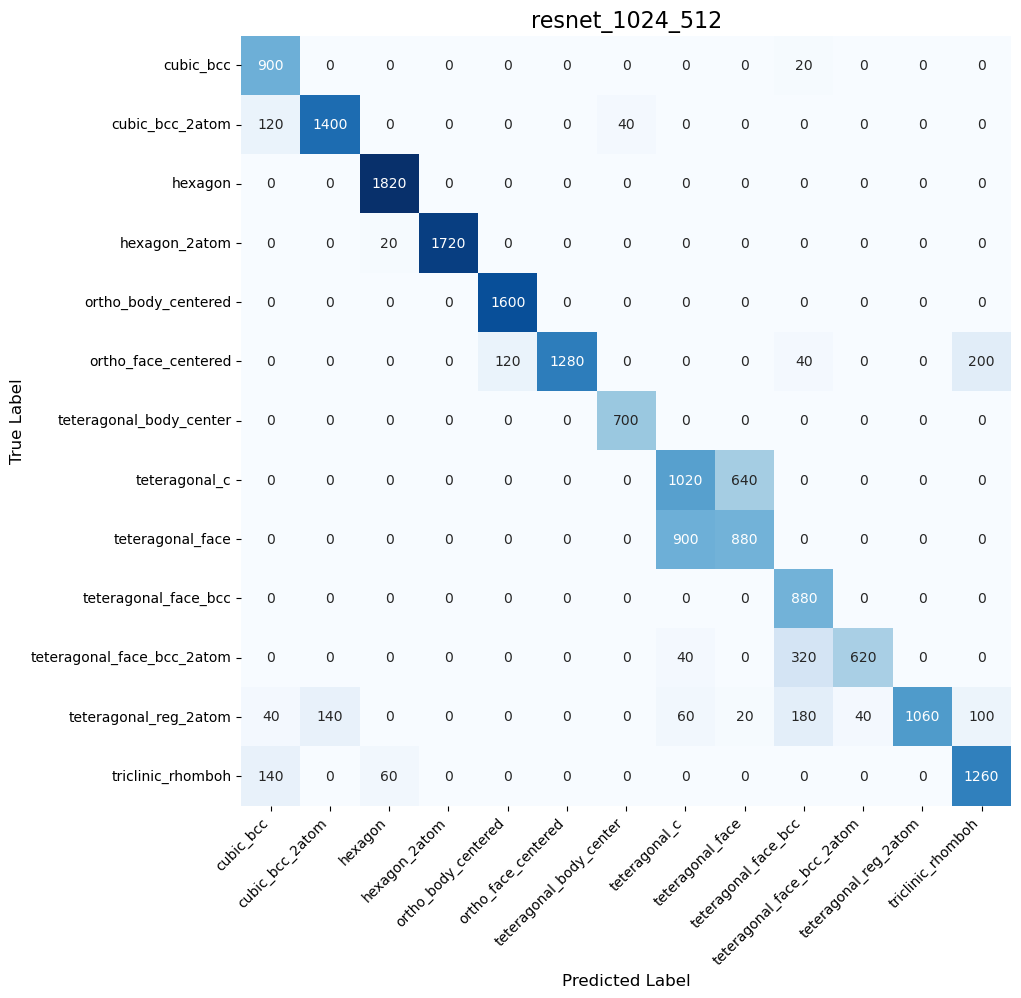

In [15]:
#Plot confusion matrix for test dataset if available, otherwise on validation dataset

# Get the predicted labels for the validation set
predicted_label = np.argmax(model.predict(valid_ds), axis =-1)

# Get the true labels for the validation set
true_classes = np.concatenate([y for x, y in valid_ds], axis=0)

#labels are one hot encoded, so convert them into the integers for confusion matrix
true_classes = np.argmax(true_classes , axis=-1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes , predicted_label)

# Define the class names
class_names = ds_valid.class_names


def plot_heatmap(y_true, y_pred, class_names, ax, title):
    """ A function to get predict
    ed and true y labels and plot a heatmap (from seaborn) of true prediction """
    cm = confusion_matrix(y_true, y_pred)
    heatmap(
            cm, 
            annot = True, 
            square= True, 
            xticklabels = class_names, 
            yticklabels = class_names,
            fmt  = "d", 
            cmap = plt.cm.Blues,
            cbar = False, 
            ax = ax
            )
    ax.set_title(title, fontsize = 16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_xlabel("Predicted Label", fontsize = 12)

fig, ax1 = plt.subplots(1, 1, figsize = (15, 10))
plot_heatmap(true_classes, predicted_label, class_names, ax1, title=title)    
plt.savefig(folder_dest +"/" + title + "_confusion_plot.png", bbox_inches = "tight")

In [16]:
# To just get confusion matrix for the validation dataset

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in valid_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

print(confusion_matrix(np.argmax(correct_labels, axis = -1), predicted_labels))

[[ 900    0    0    0    0    0    0    0    0   20    0    0    0]
 [ 120 1400    0    0    0    0   40    0    0    0    0    0    0]
 [   0    0 1820    0    0    0    0    0    0    0    0    0    0]
 [   0    0   20 1720    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0 1600    0    0    0    0    0    0    0    0]
 [   0    0    0    0  120 1280    0    0    0   40    0    0  200]
 [   0    0    0    0    0    0  700    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0 1020  640    0    0    0    0]
 [   0    0    0    0    0    0    0  900  880    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0  880    0    0    0]
 [   0    0    0    0    0    0    0   40    0  320  620    0    0]
 [  40  140    0    0    0    0    0   60   20  180   40 1060  100]
 [ 140    0   60    0    0    0    0    0    0    0    0    0 1260]]


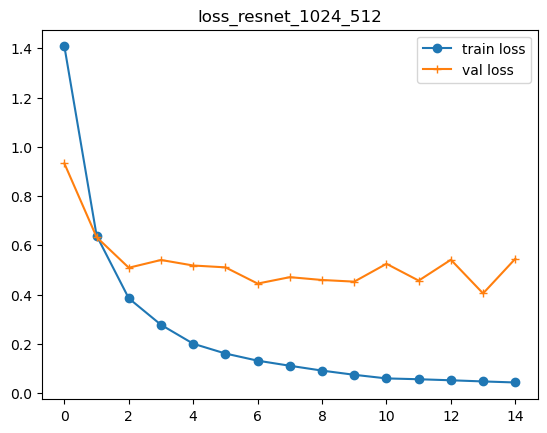

In [17]:
# Plot Loss
plt.plot(random_lattice_resnet.history["loss"], label="train loss", marker="o")
plt.plot(random_lattice_resnet.history["val_loss"], label="val loss", marker="+")
plt.legend()
plt.title(f"loss_{title}")
plt.savefig(folder_dest+"/"+title+"_loss.png")
plt.show()

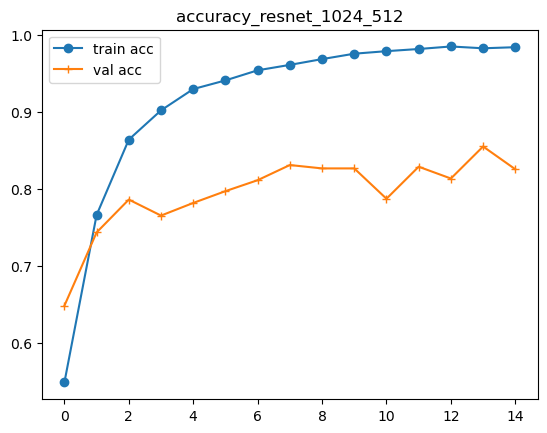

In [18]:
# Plot Accuracy
plt.plot(random_lattice_resnet.history["accuracy"], label="train acc", marker="o")
plt.plot(random_lattice_resnet.history["val_accuracy"], label="val acc", marker="+")
plt.legend()
plt.title(f"accuracy_{title}")
plt.savefig(folder_dest+"/"+title+"_accuracy.png")
plt.show()

In [19]:
#Calculate the score of train and valid sets and make a table
score_valid=model.evaluate(valid_ds, batch_size = batch_size, return_dict=True)
score_train=model.evaluate(train_ds, batch_size = batch_size, return_dict=True)

score_eval = pd.DataFrame({"score_valid" : score_valid, "score_train": score_train})
score_eval.to_csv(folder_dest + f"score evaluation {title}")
score_eval

2700/2700 [==============================] - 265s 98ms/step - loss: 0.0400 - accuracy: 0.9800


,score_valid,score_train
loss,0.546470,0.039983
accuracy,0.823721,0.979953


## Prediction a class of a random image

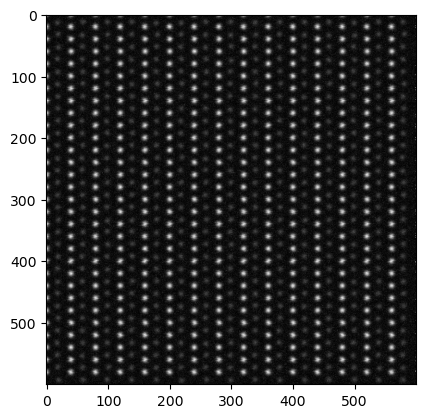

real class and the predicted class are both  teteragonal_c


In [45]:
classes = os.listdir(folder_path)

def get_random_image (image_dir):
    """ 
        A function to load and display a random image from a specified directory.
        image_dir (str): e.g. train_folder, valid_folder, test_folder.
    """
    
    # Choose a random class (label) from available classes
    random_class=np.random.choice(os.listdir(image_dir))
    
    # Select a random image from chosen class
    random_img=np.random.choice(glob(os.path.join(image_dir, random_class, "*.png")))
    
    #Load and display image
    img=image.load_img((random_img), 
                       target_size = (image_size[0], image_size[1])
                      )
    plt.imshow(img)
    plt.show()
    
    #Convert the loaded image to a format which is suitable for the model
    img_array = image.img_to_array(img)
    img_array = img_array.reshape (1, *img_array.shape) / 255.0
    
    return img_array, random_class
   
def check_image(title):
    """ 
        A function to select and display a random image, and predict its class. 
        title: the title which was chosen before to save the model, or any other title.
    """
     # Load and dispaly a random image
    img_array, random_class = get_random_image(folder_path)
    
    #Check if the predicted class is the same as the real class  
    predicted_class_value = np.argmax(model.predict(img_array), axis = -1)[0]
    predicted_class_index = classes[predicted_class_value]
             
    if predicted_class_index == random_class:
        print("real class and the predicted class are both ", random_class)
    else:
        print("real class is ", random_class," but predicted class is ", predicted_class_index )
        
check_image(title)